# Training samples

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler

In [4]:
non_training_attributes = ['changeset_id', 'changeset_harmful']

In [5]:
training = pd.read_csv('../downloads/old-feature-classifier/training.csv')
validation = pd.read_csv('../downloads/old-feature-classifier/validation.csv')

In [6]:
scores = list()
sample_sizes = list(range(250, training.shape[0], 250))
index = []
for sample_size in sample_sizes:
    temp = training.iloc[:sample_size]
    
    # Prepare datasets for model.
    X = temp.drop(non_training_attributes, axis=1)
    y = temp['changeset_harmful']

    vX = validation.drop(non_training_attributes, axis=1)
    vy = validation['changeset_harmful']

    # Train model on scaled training dataset.
    scaler = StandardScaler().fit(X)
    X_scaled = scaler.transform(X)
    model = GradientBoostingClassifier().fit(X_scaled, y)

    # Performance on validation dataset.
    vX_scaled = scaler.transform(vX)
    vy_model = model.predict(vX_scaled)
    
    score = [metric(vy, vy_model) for metric in [metrics.precision_score, metrics.recall_score, metrics.f1_score, metrics.roc_auc_score]]
    index.append(temp.shape[0])
    scores.append(score)

In [7]:
scores = pd.DataFrame(scores, columns=['precision_score', 'recall_score', 'f1_score', 'roc_auc_score'], index=index)
print(scores.shape)
scores.head()

(24, 4)


,precision_score,recall_score,f1_score,roc_auc_score
250,0.644628,0.312,0.420485,0.646784
500,0.722973,0.428,0.537688,0.705213
750,0.828358,0.444,0.578125,0.717071
1000,0.715976,0.484,0.577566,0.731713
1250,0.753165,0.476,0.583333,0.729642


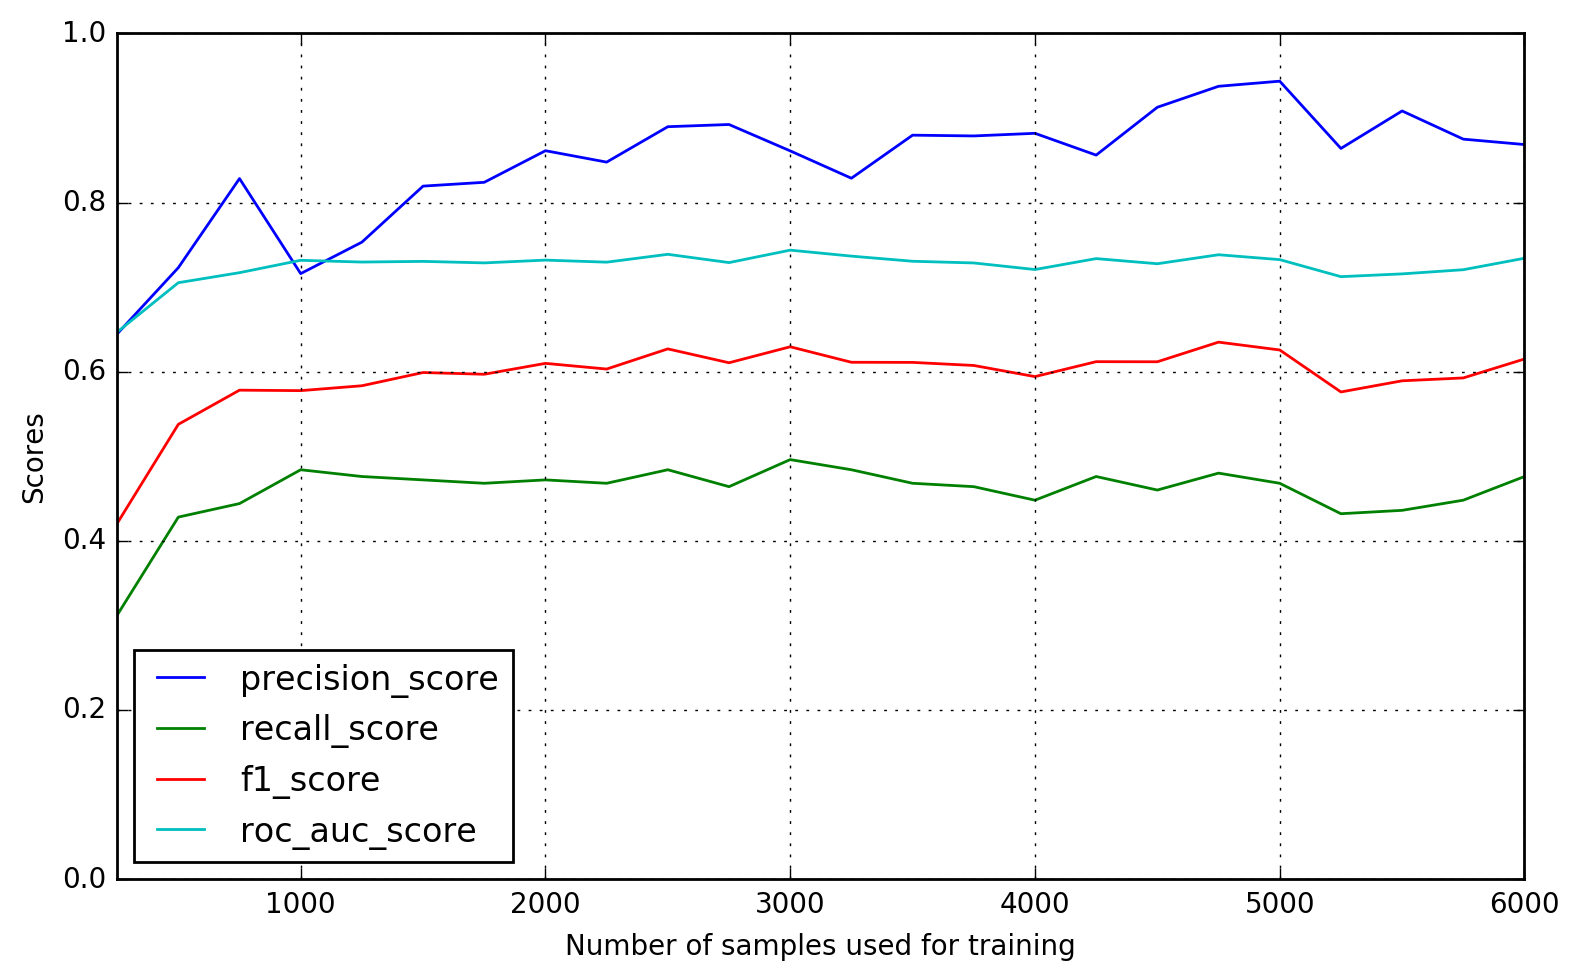

In [8]:
axes = scores.plot(figsize=(8, 5))
axes.set_xlabel('Number of samples used for training')
axes.set_ylabel('Scores')
axes.set_ylim(0, 1)
# axes.set_xticks(np.arange(0, 100, 10))
plt.grid()
plt.tight_layout()